- get rain data and visualise for overview <font color='orange'>&#9728;</font>
- cut and split data to reasonable train, val, test sets <font color='orange'>&#9728;</font>
- set up first generator and discriminator and overfit, play around with it, get first results (_November/December_)
- train on small training set and improve losses, accuracy, results (_December_)
- experiment with temporal discriminator (_December/January_)
- experiment with wind data (_January_)

## Imports and settings

In [1]:
import src
import keras.backend as K

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from os import *
import numpy as np
import sys
import re
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')

In [3]:
#forces CPU usage
environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
environ["CUDA_VISIBLE_DEVICES"] = "-1" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16160994308122934541
]


______________________________________-
## Data preprocessing

### Rain measurements
Measurements are downloaded from the DWD (German weather service) open data server: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/__<br>
I'm working with the data of August 2010 (based on [this](https://tradingeconomics.com/germany/precipitation)), so I have downloaded this: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/2010/RW-201008.tar__<br>
_DWD manual:_<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/BESCHREIBUNG_gridsgermany_hourly_radolan_historical_asc_de.pdf__<br><br>
This contains radar maps recorded in every hour. Each map has a resolution of $900\times900$ pixels and each pixel corresponds to an $1\,km\times1\,km$ area in reality. Pixel values are the precipitation height in $0.1\,mm$.
Below I'm importing the data of this as a series of numpy arrays and plot them to see the acual radar map. The _sys.path[0]_ is the path on my computer and it can be different for you.

In [46]:
def load_datasets(dataset="5min"):
    if dataset in ["5m", "5min", "5minutes", "5minute"]:
        images = np.load(sys.path[0]+"/5_minute.npy").item()
    elif dataset in ["h", "hourly"]:
        images = np.load(sys.path[0]+"/hourly.npy").item()
    train = np.reshape(images["train"],np.shape(images["train"])+(1,))
    xval = np.reshape(images["xval"],np.shape(images["xval"])+(1,))
    test = np.reshape(images["test"],np.shape(images["test"])+(1,))
    print(f"Training data: {train.shape}\nValidation data: {xval.shape}\nTest data: {test.shape}")
    return train, xval, test

In [47]:
train, xval, test = load_datasets()

Training data: (6000, 2, 64, 64, 1)
Validation data: (2000, 2, 64, 64, 1)
Test data: (2000, 2, 64, 64, 1)


In [6]:
unet_train     = np.reshape(train[:,0,:,:,:],((train.shape[0],)+train.shape[2:]))
unet_truth     = np.reshape(train[:,1,:,:,:],((train.shape[0],)+train.shape[2:]))
unet_val       = np.reshape(xval[:,0,:,:,:],((xval.shape[0],)+xval.shape[2:]))
unet_val_truth = np.reshape(xval[:,1,:,:,:],((xval.shape[0],)+xval.shape[2:]))
print(unet_train.shape,"\n",unet_truth.shape,"\n",unet_val.shape,"\n",unet_truth.shape)
unet_test      = np.reshape(test[:,0,:,:,:],((test.shape[0],)+test.shape[2:]))
unet_test_truth = np.reshape(test[:,1,:,:,:],((test.shape[0],)+test.shape[2:]))

(6000, 64, 64, 1) 
 (6000, 64, 64, 1) 
 (2000, 64, 64, 1) 
 (6000, 64, 64, 1)


In [ ]:
overfit_train = np.reshape(train[5,0,:,:,:],((1,)+train.shape[2:]))
overfit_truth = np.reshape(train[5,1,:,:,:],((1,)+train.shape[2:]))

In [ ]:
%matplotlib inline
src.visualise_data(xval[:,:,:,:,0])

## U-net

In [33]:
#model2=keras.Sequential()
def unet():
    init       = keras.layers.Input(shape=(64,64,1))
    ConvDown1  = keras.layers.Conv2D(filters=8,kernel_size=(2,2),strides=(1,1),padding="same")(init)
    Lr1        = keras.layers.LeakyReLU(alpha=0.0)(ConvDown1)
    #64
    ConvDown2  = keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2),padding="same")(Lr1)
    Lr2        = keras.layers.LeakyReLU(alpha=0.0)(ConvDown2)
    #32
    ConvDown3  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr2)
    Lr3        = keras.layers.LeakyReLU(alpha=0.0)(ConvDown3)
    #16
    ConvDown4  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr3)
    Lr4        = keras.layers.LeakyReLU(alpha=0.0)(ConvDown4)
    #8
    ConvDown5  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr4)
    Lr5        = keras.layers.LeakyReLU(alpha=0.0)(ConvDown5)
    #4

    UpSamp1 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr5)
    #8
    merge1  = keras.layers.concatenate([ConvDown4,UpSamp1],axis=-1)#(UpSamp1)
    Conv1   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge1)
    Lr6     = keras.layers.LeakyReLU(alpha=0.0)(Conv1)
    #8
    UpSamp2 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr6)
    #16
    merge2  = keras.layers.concatenate([ConvDown3,UpSamp2],axis=-1)#(UpSamp2)
    Conv2   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge2)
    Lr7     = keras.layers.LeakyReLU(alpha=0.0)(Conv2)
    #16
    UpSamp3 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr7)

    #32
    Conv3   = keras.layers.Conv2D(filters=16,kernel_size=(4,4),strides=(1,1),padding="same")(UpSamp3)
    Lr8     = keras.layers.LeakyReLU(alpha=0.0)(Conv3)

    UpSamp4 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr8)
    #64
    Conv4   = keras.layers.Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'relu')(UpSamp4)

    Conv5   = keras.layers.Conv2D(filters=1,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'elu')(Conv4)
    
    return keras.models.Model(inputs=init, outputs=Conv5)

In [34]:
model = unet()

In [35]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 64, 64, 8)    40          input_6[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_85 (LeakyReLU)      (None, 64, 64, 8)    0           conv2d_97[0][0]                  
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 32, 32, 16)   528         leaky_re_lu_85[0][0]             
__________________________________________________________________________________________________
leaky_re_l

In [36]:
#train the model
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate = 0.0001),loss=src.custom_loss(["l2", "l1", "l33"]), metrics=[src.relative_error_tensor]) 
model.fit(unet_train[:10],
          unet_truth[:10],
          batch_size = 10,
          epochs=2,
          validation_data=(unet_val[:10],unet_val_truth[:10]),
          shuffle = False)

***Using L1 + L2 loss.***
Tensor("metrics/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("conv2d_106_target:0", shape=(?, ?, ?, ?), dtype=float32)
Train on 10 samples, validate on 10 samples
Epoch 1/2
10/10 [==============================] - 2s 200ms/step - loss: 0.7886 - relative_error_tensor: 1.3419 - val_loss: 0.9253 - val_relative_error_tensor: 1.2388
Epoch 2/2
10/10 [==============================] - 0s 39ms/step - loss: 0.7506 - relative_error_tensor: 1.2904 - val_loss: 0.8853 - val_relative_error_tensor: 1.1988


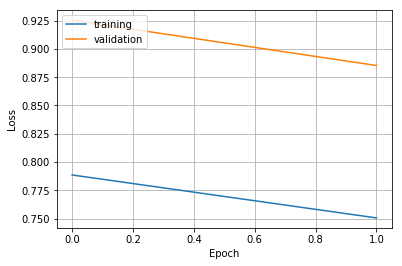

In [38]:
hist = model.history
hist.history.keys()
plt.plot(hist.history['loss'],)
plt.plot(hist.history['val_loss'])
plt.grid()
plt.legend(['training', 'validation'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.savefig('training.png')

In [39]:
#test
predictions = model.predict(unet_test, batch_size=100)
truth       = unet_test_truth
truth.shape

(2000, 64, 64, 1)

In [40]:
args = src.arg_getter(truth, predictions)
args[-1]

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:270: RuntimeWarning: divide by zero encountered in true_divide
  images[i] = np.divide(num, den)
C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:270: RuntimeWarning: invalid value encountered in true_divide
  images[i] = np.divide(num, den)


525

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:270: RuntimeWarning: divide by zero encountered in true_divide
  images[i] = np.divide(num, den)
C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:270: RuntimeWarning: invalid value encountered in true_divide
  images[i] = np.divide(num, den)


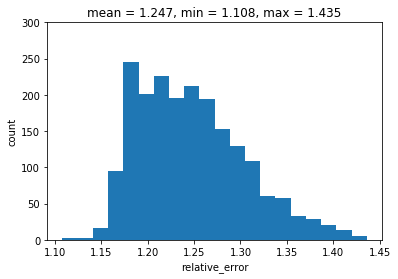

In [41]:
error_images, error_vals, error_means = src.error_distribution(truth,predictions,metric="relative_error")

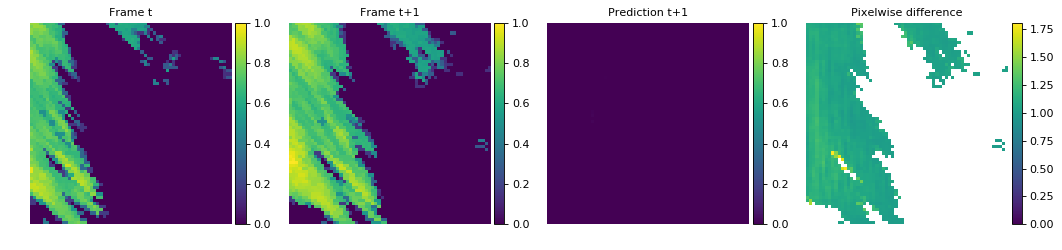

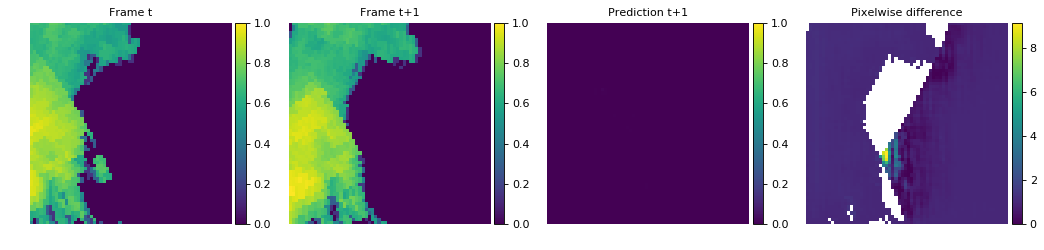

In [42]:
src.result_plotter(args[0:2], (unet_test[:,:,:,0], truth[:,:,:,0], predictions[:,:,:,0], error_images[:,:,:,0]))

Discriminator

In [45]:
#Ds = keras.Sequential()
def spatial_discriminator():
    init = keras.layers.Input(shape=(64,64,1))
    
    conv1 = keras.layers.Conv2D(filters=4 ,kernel_size=4, strides=2, padding='same')(init)
    relu1 = keras.layers.LeakyReLU(alpha=0.2)(conv1)
    dropout1 = keras.layers.Dropout(dropout)(relu1)
    
    conv2 = keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='same')(dropout1)
    relu2 = keras.layers.LeakyReLU(alpha=0.2)(conv2)
    dropout2 = keras.layers.Dropout(dropout)(relu2)
    
    conv3 = keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='same')(dropout2)
    relu3 = keras.layers.LeakyReLU(alpha=0.2)(conv3)
    dropout3 = keras.layers.Dropout(dropout)(relu3)
    
    conv4 = keras.layers.Conv2D(filters=32, kernel_size=4, strides=2, padding='same')(dropout3)
    relu4 = keras.layers.LeakyReLU(alpha=0.2)(conv4)
    dropout4 = keras.layers.Dropout(dropout)(relu4)
    
    # Out: 1-dim probability
    flatten = keras.layers.Flatten()(dropout4)
    fcl1 = keras.layers.Dense(1)(flatten)
    sig1 = keras.layers.Activation('sigmoid')(fcl1)
    
    return keras.models.Model(inputs=init, outputs=sig1)

In [52]:
#modified from source: https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py
class GAN():
    def __init__(self):
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.metric = [src.relative_error_tensor]

        optimizer = keras.optimizers.Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=self.metric)

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        input_img = keras.layers.Input(shape=self.img_shape)
        generated = self.generator(input_img)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(generated)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = keras.models.Model(input_img, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self,network="U-net"):  
        generator = keras.Sequential()
        if network in ["Unet", "U-net", "unet", "u-net"]:
            return unet()

    def build_discriminator(self):
        return spatial_discriminator()

    def train(self, epochs, dataset="5min", batch_size=128, sample_interval=50):

        # Load the dataset
        train, xval, test = load_datasets()
        unet_train     = np.reshape(train[:,0,:,:,:],((train.shape[0],)+train.shape[2:]))
        unet_truth     = np.reshape(train[:,1,:,:,:],((train.shape[0],)+train.shape[2:]))
        unet_val       = np.reshape(xval[:,0,:,:,:],((xval.shape[0],)+xval.shape[2:]))
        unet_val_truth = np.reshape(xval[:,1,:,:,:],((xval.shape[0],)+xval.shape[2:]))
        print(unet_train.shape,"\n",unet_truth.shape,"\n",unet_val.shape,"\n",unet_truth.shape)
        unet_test      = np.reshape(test[:,0,:,:,:],((test.shape[0],)+test.shape[2:]))
        unet_test_truth = np.reshape(test[:,1,:,:,:],((test.shape[0],)+test.shape[2:]))
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, unet_truth.shape[0], batch_size)
            real_imgs = unet_truth[idx]
            idx2 = np.random.randint(0, unet_train.shape[0], batch_size)
            training_batch = unet_train[idx2]

            # Generate a batch of new images
            generated_imgs = self.generator.predict(training_batch)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(real_imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(generated_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            idx3 = np.random.randint(0, unet_train.shape[0], batch_size)
            training_batch = unet_train[idx3]

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(training_batch, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        idx = np.random.randint(0, unet_test.shape[0], 25)
        test_batch = unet_test[idx]
        gen_imgs = self.generator.predict(test_batch)

        fig, axs = plt.subplots(5, 5)
        cnt = 0
        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("Plots/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=3, batch_size=32, sample_interval=1)

Tensor("metrics_5/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("activation_14_target:0", shape=(?, ?), dtype=float32)
Training data: (6000, 2, 64, 64, 1)
Validation data: (2000, 2, 64, 64, 1)
Test data: (2000, 2, 64, 64, 1)
(6000, 64, 64, 1) 
 (6000, 64, 64, 1) 
 (2000, 64, 64, 1) 
 (6000, 64, 64, 1)
0 [D loss: 0.695639, acc.: inf%] [G loss: 0.692716]
1 [D loss: 0.698065, acc.: inf%] [G loss: 0.694184]
2 [D loss: 0.694413, acc.: inf%] [G loss: 0.690985]
